# Neural Style Transfer

In neural style transfer we take as input two images, a *content* image and *style reference* image, and we blend them such that the *content* image inherites the style of the *style reference* image.

Our content and style images are the following:



<img src="https://images.fineartamerica.com/images/artworkimages/mediumlarge/2/language-of-light-vesna-delevska.jpg" width="500px"/>

[Language Of Light](https://fineartamerica.com/featured/language-of-light-vesna-delevska.html) by Vesna Delevska

<img src="https://c8.alamy.com/comp/TX4MAF/portrait-of-three-tame-alpacas-wearing-bow-ties-TX4MAF.jpg" width="500px"/>

[Tame Alpacas Wearing Bow Ties](https://www.alamy.com/portrait-of-three-tame-alpacas-wearing-bow-ties-image257029991.html?pv=1&stamp=2&imageid=5F566255-007B-4CD1-B9C9-39A789B1CEC0&p=823921&n=0&orientation=0&pn=1&searchtype=0&IsFromSearch=1&srch=foo%3dbar%26st%3d0%26pn%3d1%26ps%3d100%26sortby%3d2%26resultview%3dsortbyPopular%26npgs%3d0%26qt%3dbow%2520ties%26qt_raw%3dbow%2520ties%26lic%3d3%26mr%3d0%26pr%3d0%26ot%3d0%26creative%3d%26ag%3d0%26hc%3d0%26pc%3d%26blackwhite%3d%26cutout%3d%26tbar%3d1%26et%3d0x000000000000000000000%26vp%3d0%26loc%3d0%26imgt%3d0%26dtfr%3d%26dtto%3d%26size%3d0xFF%26archive%3d1%26groupid%3d%26pseudoid%3d%26a%3d%26cdid%3d%26cdsrt%3d%26name%3d%26qn%3d%26apalib%3d%26apalic%3d%26lightbox%3d%26gname%3d%26gtype%3d%26xstx%3d0%26simid%3d%26saveQry%3d%26editorial%3d1%26nu%3d%26t%3d%26edoptin%3d%26customgeoip%3d%26cap%3d1%26cbstore%3d1%26vd%3d0%26lb%3d%26fi%3d2%26edrf%3d%26ispremium%3d1%26flip%3d0%26pl%3d)

### Setup

In [35]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [36]:
#we store our data in gdrive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Define helper function to output results

In [37]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Get content image and style reference image

In [38]:
content_path = '/gdrive/MyDrive/Colab Notebooks/projects/neural_style/alpacas.jpeg'
style_path = '/gdrive/MyDrive/Colab Notebooks/projects/neural_style/style_art.jpeg'

### Visualize Input

In [39]:
#image loading helper
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create helper function to display image:

In [40]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

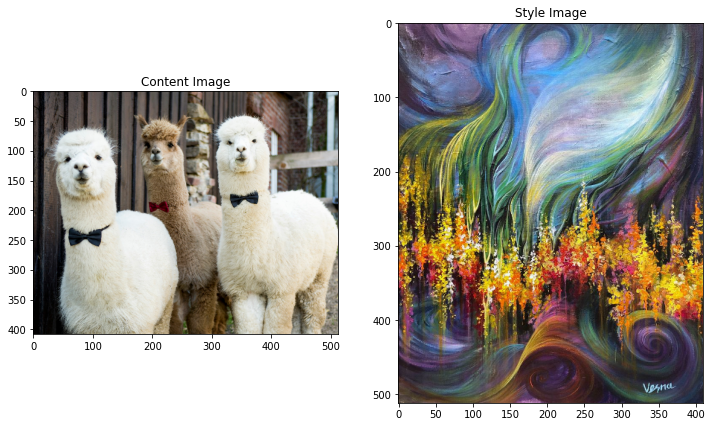

In [41]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Content and Style Representation in Model

In order to get the content and/or style of an image, we need to use the intermediate layers of our model. The first few layer activations capture low-level features such as edges and textures, whereas the last few layers capture higher-level details such as faces and bow ties.

Here, we will use the VGG19 network architecture. For an input image, we will try to match the style of the style image with the content of the content image within the intermediate layers.

Load VGG19 without the classification head, and list the layer names

In [42]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Get intermediate layers fro network to represent style and content of image:

In [43]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Build Model

Build a VGG19 model that returns a list of intermediate layers as output:


In [44]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Create model components

In [45]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

### Calculate Style

Content of the image can be represented by values of the intermediate feature maps.

Style of an image can be described by the means and correlation across different feature maps. The Gram Matrix calculation quantifies this objective well:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$


In [46]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### Full Model

In [47]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [48]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

### Optimize Model

Implement the style transfer algorithm by calculating the MSE of the image's output relative to each target, followed by taking a weighted sum of the losses

In [49]:
#target values
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#optimizing variable
image = tf.Variable(content_image)

#float [0,1] interval clipper
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#create optimizer, choose ADAM (LBFGS is good too)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#to optimize, use weighted combination of content and style loss
style_weight = 1e-2
content_weight = 1e4

Define style-content loss function

In [50]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Define training step

In [51]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Perform optimization:

In [52]:
import time

def optimize():
  start = time.time()

  epochs = 10
  steps_per_epoch = 100

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
      print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    
  end = time.time()
  print("Total time: {:.1f}".format(end-start))

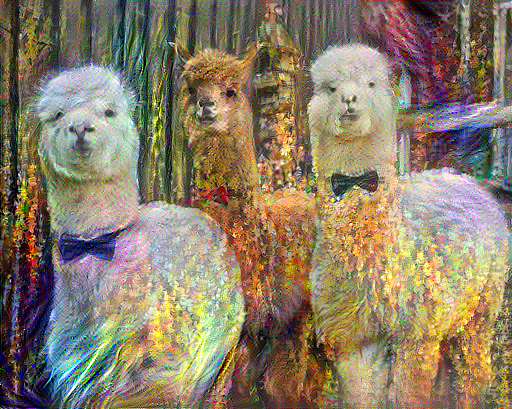

Train step: 1000
Total time: 5707.1


In [53]:
optimize()

### Total Variation Loss

Our implementation currently produces many high frequency artifacts. We can reduce these by using an explicit regularization term on the high frequency components of the imange, ie Total Variation Loss

In [54]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

### Re-Optimize

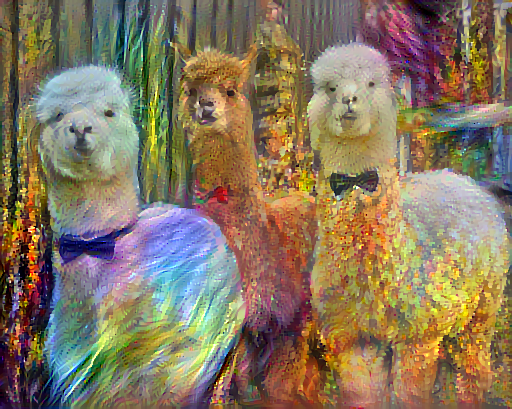

Train step: 1000
Total time: 5739.3


In [55]:
#total variation loss weight
total_variation_weight = 30

#include varition loss weight in train step
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

#reinitialize optimization variable
image = tf.Variable(content_image)

#run optimization
optimize()

Save result:

In [56]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>